In [1]:
# imports

import pandas as pd
import pathlib
import seaborn as sns
import numpy as np

In [2]:
# constants

raw_csv_file = r"./mibitof_tnbc_pred_cell_type.csv"
raw_patient_class_file = './patient_class_survival_days.csv'
root_data_dir =  '../../data'
output_graphs_dir = './MIBITOF_TNBC_Tutorial/'

FANMOD_path = "C:\\Users\\User\\source\\repos\\fanmod-cmd\\out\\build\\x64-release" #this should be updated
FANMOD_exe = "LocalFANMOD.exe"
output_dir = './../../fanmod_output'
cache_dir = './../../parse_cache'

cism_project_root_path = 'C:\\Users\\milsh\\PycharmProjects\\CISM'

# CISM tutorial

## Greeting 

Hi welcome to Context-dependent Identification of Spatial Motifs (CISM) tutorial.

This tutorial demonstrates how to analyze and extract discriminative motifs for triple negative breast cancer dataset - a published MIBI-TOF-acquired human cohort TNBC dataset (Keren et al., 2018).

From copyrights and respect to the creators of the dataset, the original protein expression and the images should be downloaded from https://www.angelolab.com/mibi-data and segmented into n (n=16) cell types.

Here we skip that process and simplify the initial data preprocessing and assume that we already have a single csv table in the following format:

Required table header (there could be more):
1. idx: row index
2. patient_id: patient identifier
3. fov: field-of-view identifier
4. cell_id: cell identifier
5. centroid-0: x-axis cell centroid location
6. centroid-1: y-axis cell centroid location
7. pred: cell type class

Let's load the dataset:

In [3]:
raw_df = pd.read_csv(filepath_or_buffer=raw_csv_file, index_col=0)
raw_df

,patient_id,fov,cell_id,centroid-0,centroid-1,pred
0,1,1,2,158.335616,32.856164,4
1,1,1,3,191.294118,30.588235,8
2,1,1,4,212.325581,30.232558,4
3,1,1,5,269.985782,34.772512,4
4,1,1,6,381.175141,35.344633,10
...,...,...,...,...,...,...
193140,40,40,4853,1051.963855,1905.380723,3
193141,40,40,4854,1497.019231,1908.338462,4
193142,40,40,4855,1780.661538,1902.561538,3
193143,40,40,4856,976.139785,1906.268817,4


In [4]:
raw_df.patient_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40], dtype=int64)

In [5]:
print(f'we have {raw_df.patient_id.nunique()} patients and {raw_df.fov.nunique()} FOVs')

we have 38 patients and 39 FOVs


In [6]:
raw_df = raw_df[raw_df.patient_id != 38]

Later on in the next sections we are going to use the clinical readout of patient survival days. Since the information is not valid for patient 38 we have less patients:

In [7]:
print(f'we have {raw_df.patient_id.nunique()} patients and {raw_df.fov.nunique()} FOVs')

we have 37 patients and 38 FOVs


## Generating the FOV graphs

First we need to define a map from the prediction identifier to cell type. In that stage some of the cell type if needed would be consolidated to a lower resolution

In [8]:
cells_mapper = {
  1: 'Unidentified',
  2: 'Endothelial',
  3: 'Mesenchyme',
  4: 'Tumor',
  5: 'Tregs',
  6: 'CD4 t cells',
  7: 'CD8 T cells',
  8: 'CD3 T cells',
  9: 'NK cells',
  10: 'B cells',
  11: 'Neutrophils',
  12: 'Macrophages',
  13: 'DC',
  14: 'DC/Mono',
  15: 'Mono/Neu',
  16: 'Immune other'
}

We defined the spatial multicellular network, where single cells define the network nodes and are “colored” according to their cell type. Close-adjacent pairs of cells are connected with an edge using the Delaunay triangulation, excluding those edges between cells that are more distant than 50 µm away from one another.

In [28]:
# Changing directories so we can import CISM objects
import os
os.chdir(cism_project_root_path)

In [11]:
from cism.graph.create_formatted_graph import GraphBuilder

colnames_mapper_dict = {'cell_types' : 'pred', #here we configure which column holds the information of cell type
                        'patient_id' : 'patient_id'}

g = GraphBuilder(raw_df, cells_mapper, colnames_mapper_dict)

# create the folder if not exist
pathlib.Path(root_data_dir + output_graphs_dir).mkdir(exist_ok=True, parents=True)

g.build_graph(path_to_output_dir=root_data_dir + output_graphs_dir, 
              #50 µm - the maximum distance between cells to be considered neighbours. 
              #The paramter value is 100 since the resolution is 0.5 µm.
              max_distance=100,
              exclude_cell_type=None)

{'B cells': 0, 'CD3 T cells': 1, 'CD4 t cells': 2, 'CD8 T cells': 3, 'DC': 4, 'DC/Mono': 5, 'Endothelial': 6, 'Immune other': 7, 'Macrophages': 8, 'Mesenchyme': 9, 'Mono/Neu': 10, 'NK cells': 11, 'Neutrophils': 12, 'Tregs': 13, 'Tumor': 14, 'Unidentified': 15}


When the graph is created, the cell types are encoded with numbers. The g.common_cell_type_mapper holds the above printed list.
We will need the opposite mapping to initiate the CISM object.

In [10]:
cells_type = {v:k for k, v in g.common_cell_type_mapper.items()}
cells_type

{0: 'B cells',
 1: 'CD3 T cells',
 2: 'CD4 t cells',
 3: 'CD8 T cells',
 4: 'DC',
 5: 'DC/Mono',
 6: 'Endothelial',
 7: 'Immune other',
 8: 'Macrophages',
 9: 'Mesenchyme',
 10: 'Mono/Neu',
 11: 'NK cells',
 12: 'Neutrophils',
 13: 'Tregs',
 14: 'Tumor',
 15: 'Unidentified'}

## Preprearing the patinet class file

From https://www.angelolab.com/mibi-data, the mmc2.csv file of TNBC contains the surivial days of each patient. 
We need to create a file in the following format:

    <disease tag><patient id>, <class>

We prepared the file for the demo with the following data (first 5 lines):

In [11]:
# Changing directories back to the tutorial
import os
os.chdir(cism_project_root_path + '\\analysis\\Tutorial')

In [14]:
survival_days_df = pd.read_csv(raw_patient_class_file, 
                               names=['Patient', 'Survival Days'])

survival_days_df.head(5)

,Patient,Survival Days
0,TNBC1,2612
1,TNBC10,3822
2,TNBC11,3774
3,TNBC12,4353
4,TNBC13,1072


We need to define a cutoff for binary quantization. We define cutoff of 1000 days.

In [12]:
survival_rate_cutoff = 1000

def map_survival_rate_to_class(survival_rate: int):
    if survival_rate<survival_rate_cutoff:
        return 'Short-term survival'
    else:
        return 'Long-term survival'
    
classes = ['Short-term survival', 'Long-term survival']

[Text(0, 0.5, 'Fraction of patient count')]

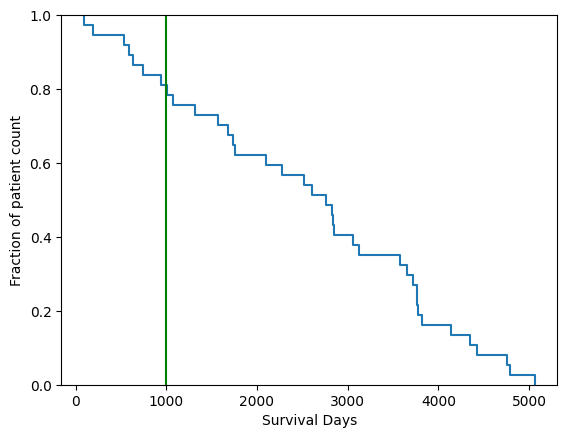

In [13]:
ax = sns.ecdfplot(survival_days_df['Survival Days'], complementary=True)
ax.axvline(x = survival_rate_cutoff,  color='g')
ax.set(ylabel='Fraction of patient count')

## Initiate CISM

Paramters:
1. motif size - Here we choose to use motif size of 3, but exploration should be done to choose the right size.
2. iterations - 1000 random networks are recommended for statistical test that measure the proability of generating random network that contains the subgraph. 


Validate the fanmod+ binary is accessable:

In [14]:
assert pathlib.Path(FANMOD_path + "\\" + FANMOD_exe).exists()

Running fanmod+ to extract motifs data for each field of view

In [15]:
# Changing directories so we can import CISM objects
import os
os.chdir(cism_project_root_path)

In [32]:
from cism.cism import CISM

motif_size = 3
iterations = 1000

cism = CISM(fanmod_exe=FANMOD_exe,
            fanmod_path=FANMOD_path,
            network_dataset_root_path=root_data_dir,
            fanmod_output_root_path=output_dir,
            fanmod_cache_root_path=cache_dir,
            motif_size=motif_size,
            iterations=iterations)


# adding the dataset
cism.add_dataset(output_graphs_dir, 
                 'Disease', 
                 'TNBC', 
                 force_run_fanmod=False, 
                 force_parse=False, 
                 n_jobs=12)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Initiate the discriminator engine with the patient classes:

In [16]:
# Changing directories back to the tutorial
import os
os.chdir(cism_project_root_path + '\\analysis\\Tutorial')

In [35]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey

discriminator = TissueStateDiscriminativeMotifs(cism=cism,
                                                tissue_state_csv_path=raw_patient_class_file,
                                                tissue_state_to_string=None,
                                                common_cells_type=cells_type,
                                                tissue_state_func=map_survival_rate_to_class)

Let's see how many patients we have for each diease state:

In [17]:
discriminator.get_patients_class(classes=None).groupby('patient_class').count()

,patient_class_id
patient_class,
Long-term survival,30
Short-term survival,7


## Calibrate the discrimination_stringency_parameter

Discrimination stringency parameter is the fraction of patients of a given disease state (i.e., short-term survival versus long-term survival) that share a discriminating motif. 

We can observe the number of discriminative motifs in respect to the discrimination stringency parameter. Here we considered the whole dataset.


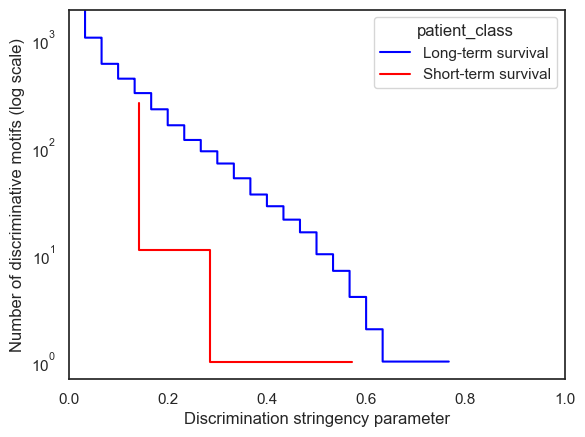

In [18]:
import warnings # To suppress some warnings
 
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

class_to_color = {
    'Short-term survival': 'red',
    'Long-term survival': 'blue',
}

sns.set(font_scale=1)
sns.set_style("white")

discover_result = discriminator.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=classes)

discover_result.plot_number_of_motifs_versus_discrimination_stringency_parameter(class_to_color=class_to_color)

This analysis showed that the number of discriminative motifs in Short-term survival and Long-term survival exponentially decayed as a function of the discrimination_stringency_parameter (with the corresponding disease state) that shared the motif.


To systematically test whether discriminative motifs can provide a rich representation of the tissue disease state, we will use machine learning validation:

In [19]:
results_table = None
random_state = np.random.RandomState(0)

In [20]:
# Changing directories so we can import CISM objects
import os
os.chdir(cism_project_root_path)

In [41]:
from cism.cism import HardDiscriminativeFC, SoftDiscriminativeFC, DiscriminativeFeatureKey
import itertools

for left_class, right_class in itertools.combinations(classes, 2):
    for th in [0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.75, 0.8]:
        try:
            print(f'task: {left_class} - {right_class}')
            featureConf = HardDiscriminativeFC(
                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                use_cells_type_composition=False,
                use_motifs=True,
                shared_percentage=th,
                max_class_features=30,
                labels=[left_class, right_class])

            motif_space_features = (discriminator
                                    .get_features(feature_conf=featureConf,
                                                  exclude_patients=[],
                                                  n_jobs=1))

            optimal_result = (discriminator
                              .analyze_motifs(feature_conf=featureConf,
                                              exclude_patients=[],
                                              n_jobs=1,
                                              random_state=random_state))

            print(f'classes: {[left_class, right_class]} '
                  f'th:{th} score: {optimal_result.get_roc_auc_score()}')

            all_motif_features = []
            for idx, row in motif_space_features.iterrows():
                all_motif_features += row['features']
            all_motif_features = list(set(all_motif_features))

            motif_freq = []
            motif_count = []
            motifs_dataset = discriminator.cism.motifs_dataset
            for motif_id in all_motif_features:
                motif_mean_freq = motifs_dataset[motifs_dataset['ID'] == motif_id]['Freq'].mean()
                motif_mean_count = motifs_dataset[motifs_dataset['ID'] == motif_id]['Count'].mean()
                motif_patients_count = motifs_dataset[motifs_dataset['ID'] == motif_id]['Patient_uId'].nunique()
                motif_freq.append(motif_mean_freq)
                motif_count.append(motif_mean_count)

            results_table = pd.concat([pd.DataFrame(
                                            {'th': th,
                                             'task': left_class + '-' + right_class,
                                             'left_class': left_class,
                                             'right_class': right_class,
                                             'roc_auc_score': optimal_result.get_roc_auc_score(),
                                             'all_motif_features': all_motif_features,
                                             'motif_mean_freq': motif_freq,
                                             'motif_mean_count': motif_count,
                                             'patient_count': motif_patients_count}),
                                             results_table], ignore_index=True)
        except Exception as e:
            break

task: Short-term survival - Long-term survival


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

classes: ['Short-term survival', 'Long-term survival'] th:0.2 score: 0.6452380952380952
task: Short-term survival - Long-term survival


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

classes: ['Short-term survival', 'Long-term survival'] th:0.3 score: 0.7357142857142858
task: Short-term survival - Long-term survival


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

classes: ['Short-term survival', 'Long-term survival'] th:0.4 score: 0.8142857142857143
task: Short-term survival - Long-term survival


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

classes: ['Short-term survival', 'Long-term survival'] th:0.45 score: 0.8809523809523809
task: Short-term survival - Long-term survival


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

classes: ['Short-term survival', 'Long-term survival'] th:0.5 score: 0.7904761904761904
task: Short-term survival - Long-term survival


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

classes: ['Short-term survival', 'Long-term survival'] th:0.6 score: 0.7333333333333334
task: Short-term survival - Long-term survival


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

classes: ['Short-term survival', 'Long-term survival'] th:0.7 score: 0.7333333333333333
task: Short-term survival - Long-term survival


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

classes: ['Short-term survival', 'Long-term survival'] th:0.75 score: 0.7333333333333334
task: Short-term survival - Long-term survival


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

We can see from the above results that 0.45 is the sweet point between of how many patients the motif must be exist and the AUC score.

Let's get the motifs for 0.45:

In [42]:
from cism.cism import GetMotifsResult

featureConf = HardDiscriminativeFC(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                   use_cells_type_composition=False,
                                   use_motifs=True,
                                   shared_percentage=0.45,
                                   max_class_features=30,
                                   labels=classes)

motif_space_features = discriminator.get_features(feature_conf=featureConf,
                                                  exclude_patients=[],
                                                  n_jobs=1)

get_motifs_result = GetMotifsResult(motif_space_features=motif_space_features,
                                   discriminator=discriminator,
                                   classes=classes)

  0%|          | 0/37 [00:00<?, ?it/s]

In [43]:
print(f'we have {len(get_motifs_result.all_motif_features)} discriminative motifs')

we have 31 discriminative motifs


## Generate the motif-induced disease state

motif_id: 8202636, hash_id: -395158436373686009


Text(0.5, 1.0, 'Short-term survival motif-induced disease state')

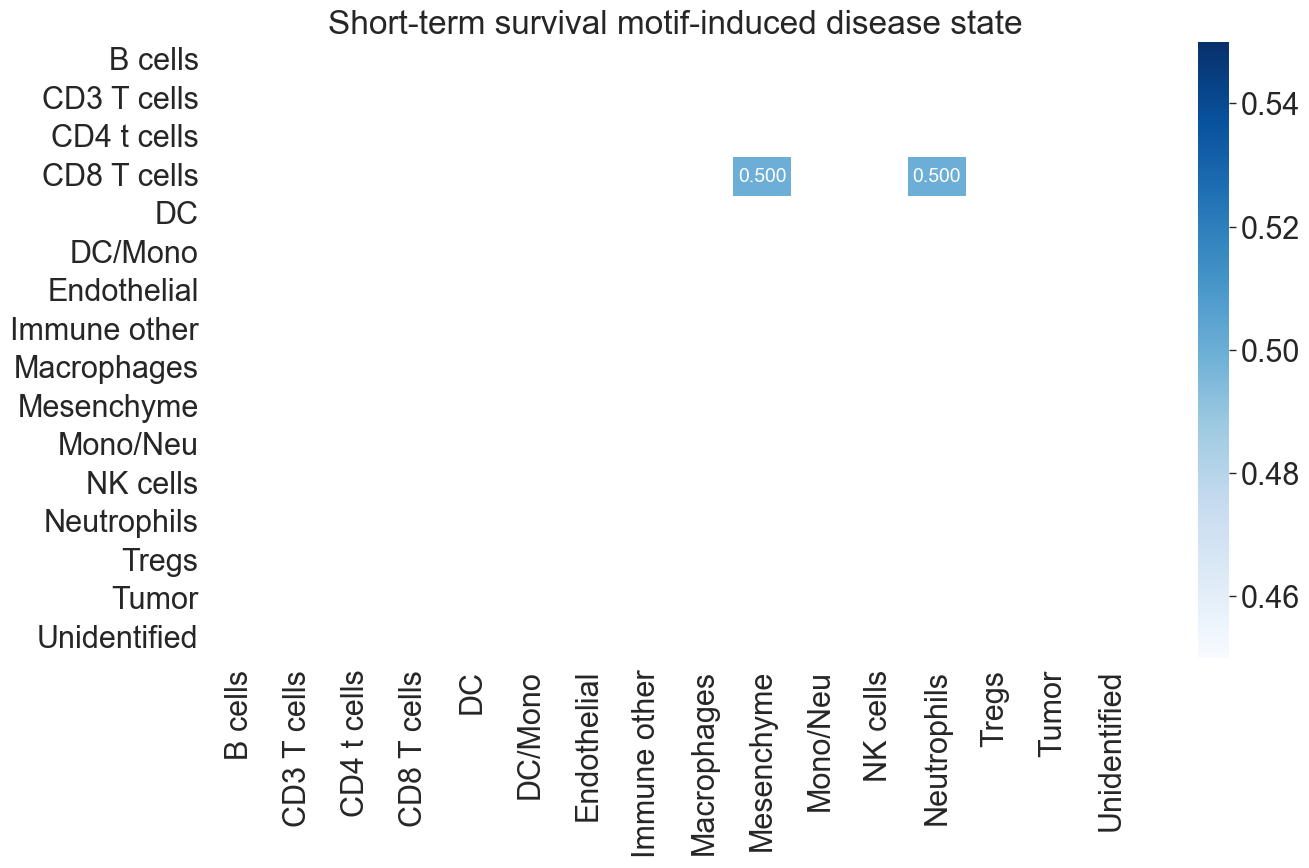

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt
from cism.helpers import create_weight_matrix_from_motifs

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

df = create_weight_matrix_from_motifs(discriminator=discriminator,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=get_motifs_result.cell_identity_to_motif_hash,
                                      motifs_ids=get_motifs_result.get_motifs_by_class()[classes[0]],
                                      motifs_weight=get_motifs_result.get_motifs_mean_weight())

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")
ax.set_title(f'{classes[0]} motif-induced disease state')

motif_id: 6052972, hash_id: 6296317540562037293
motif_id: 11058348, hash_id: -3622911041628419534
motif_id: 12369068, hash_id: -3622911041628419534
motif_id: 6077900, hash_id: 6794497112851034106
motif_id: 4750508, hash_id: 6512495239480086935
motif_id: 6061228, hash_id: 6512495239480086935
motif_id: 6061356, hash_id: -5592926003202999446
motif_id: 6077612, hash_id: 391868164882289572
motif_id: 3955948, hash_id: 1953587682041931478
motif_id: 6094060, hash_id: -8232997633730303071
motif_id: 5567724, hash_id: -8232997633730303071
motif_id: 3955884, hash_id: 6212072527860847364
motif_id: 6053164, hash_id: 5203983912965418814
motif_id: 1866860, hash_id: 3580840254939402609
motif_id: 1867212, hash_id: 3846638627528876859
motif_id: 6053036, hash_id: -8854845265688850345
motif_id: 6072588, hash_id: -4826981390596129394
motif_id: 6110508, hash_id: 781045198055153758
motif_id: 1858668, hash_id: -2723953054276735933
motif_id: 1866924, hash_id: 5566782625218365255
motif_id: 18726348, hash_id: 704

Text(0.5, 1.0, 'Short-term survival motif-induced disease state')

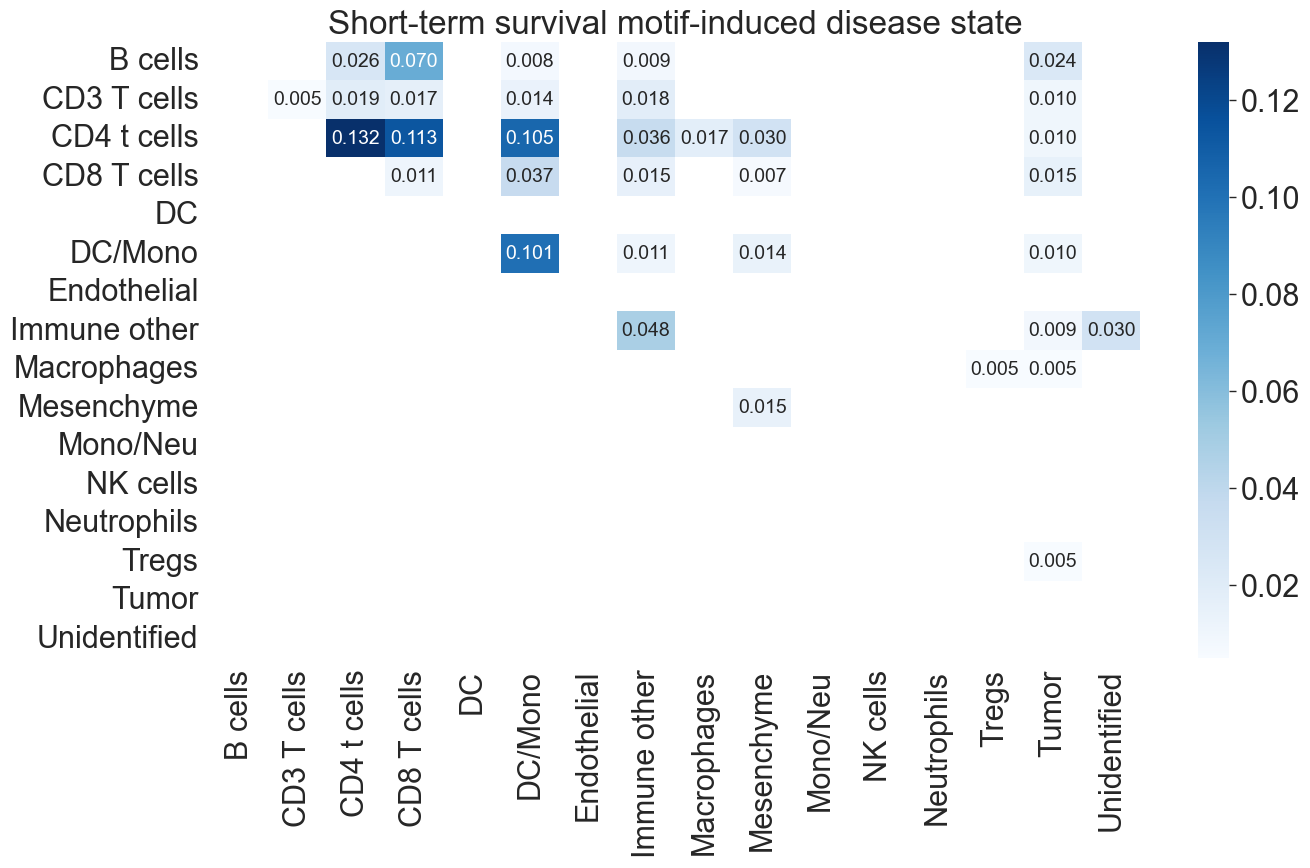

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
from cism.helpers import create_weight_matrix_from_motifs

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

df = create_weight_matrix_from_motifs(discriminator=discriminator,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=get_motifs_result.cell_identity_to_motif_hash,
                                      motifs_ids=get_motifs_result.get_motifs_by_class()[classes[1]],
                                      motifs_weight=get_motifs_result.get_motifs_mean_weight())

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")
ax.set_title(f'{classes[0]} motif-induced disease state')

## Draw the discriminative motif

motif_id: 3454124, hash_id: 8938787699188410565


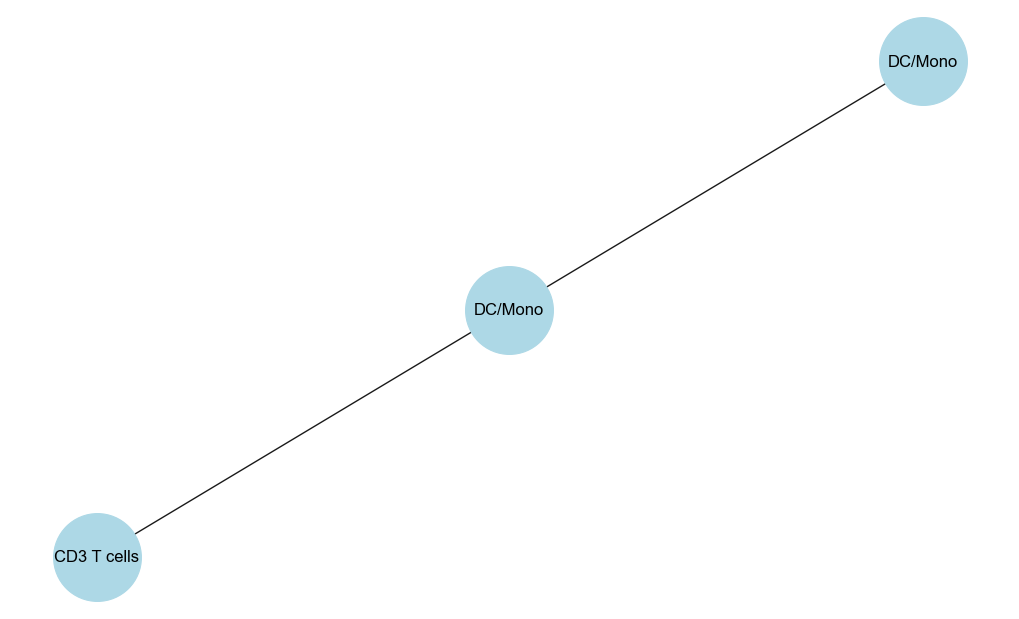

motif_id: 3964140, hash_id: 4850565862245278349


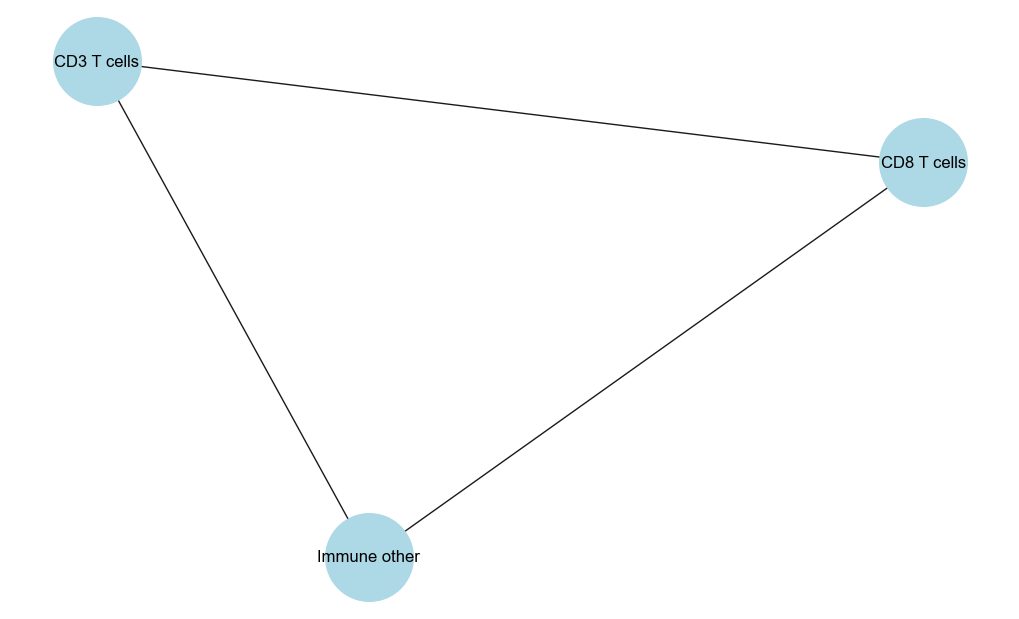

motif_id: 12385516, hash_id: -5166752284939523464


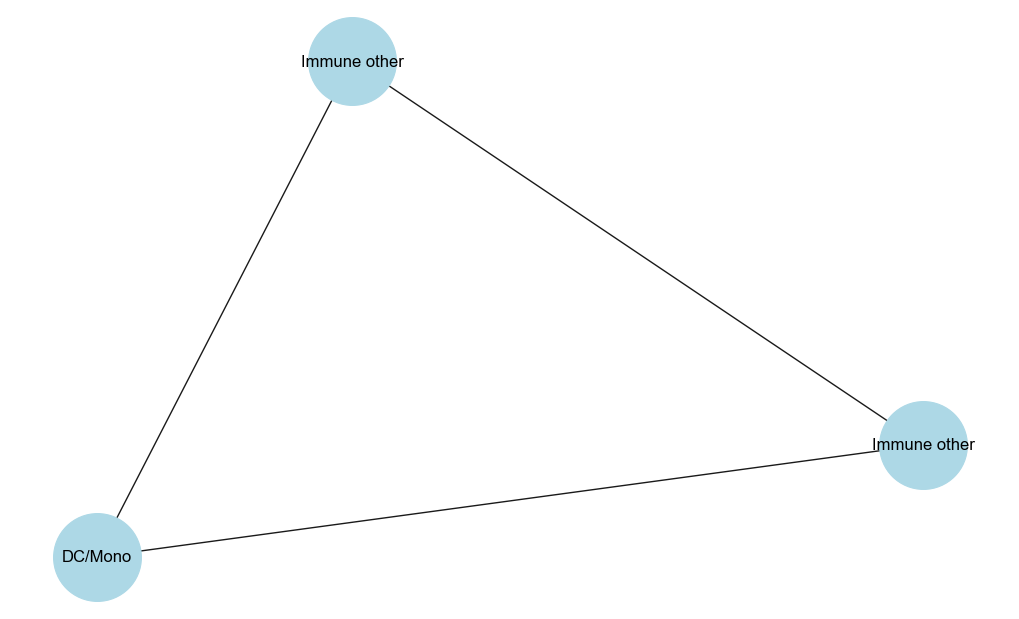

motif_id: 6072588, hash_id: -4826981390596129394


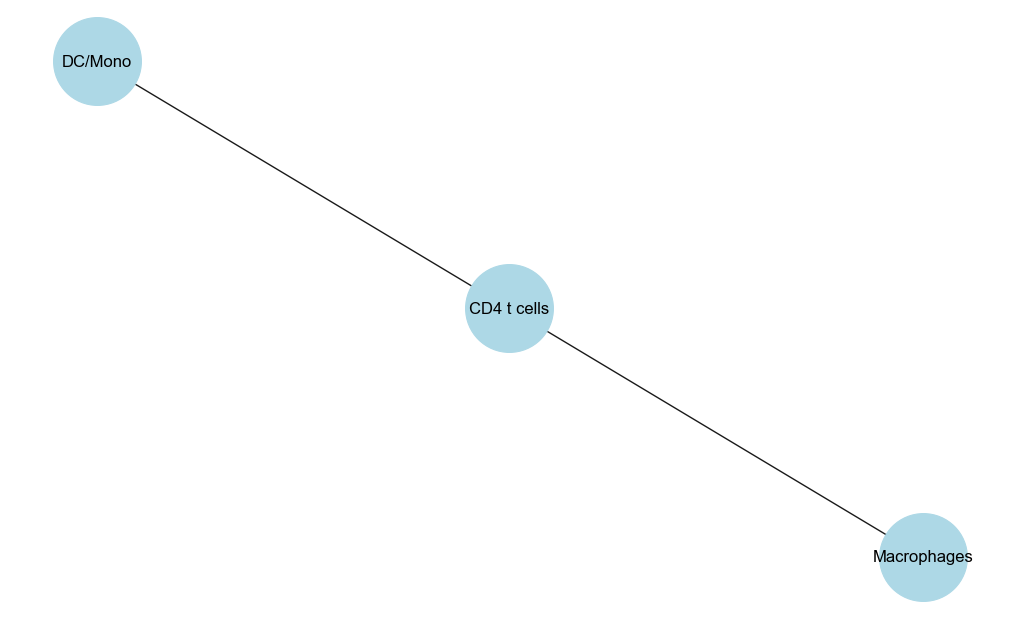

motif_id: 8202636, hash_id: -395158436373686009


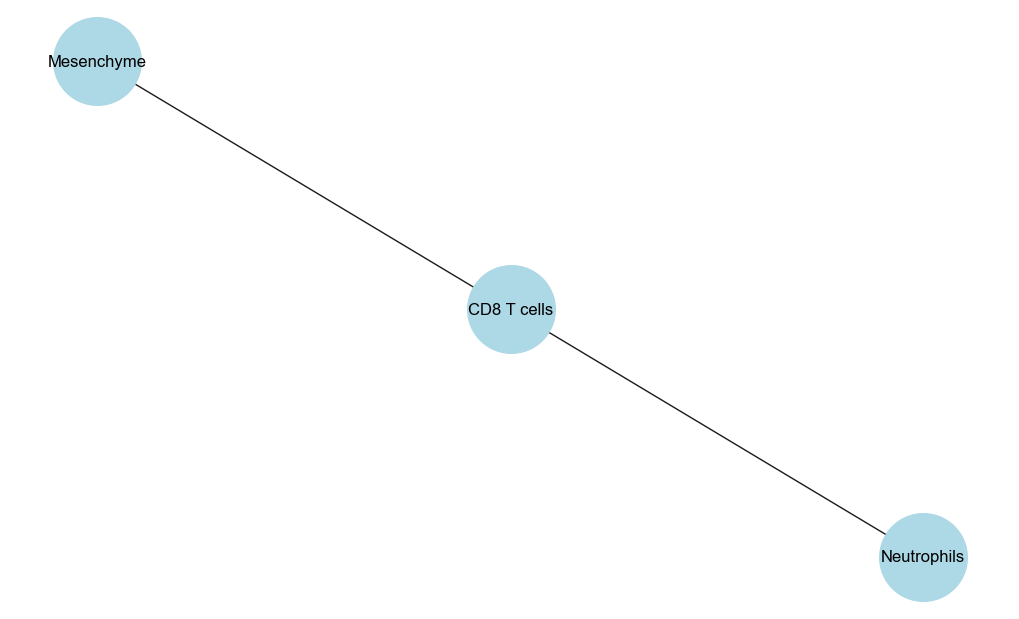

motif_id: 3955884, hash_id: 6212072527860847364


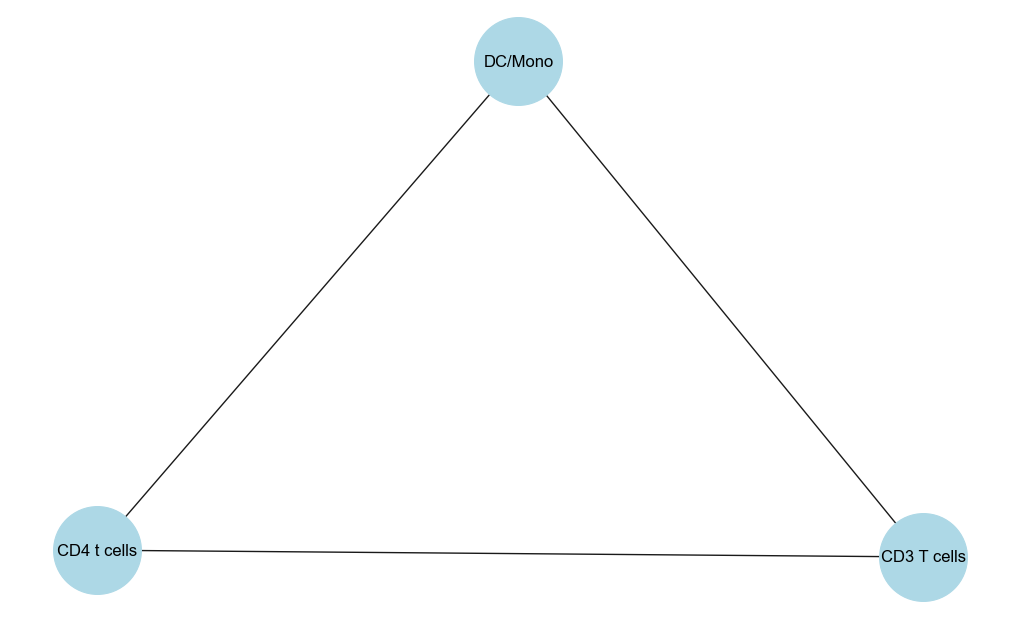

motif_id: 6053036, hash_id: -8854845265688850345


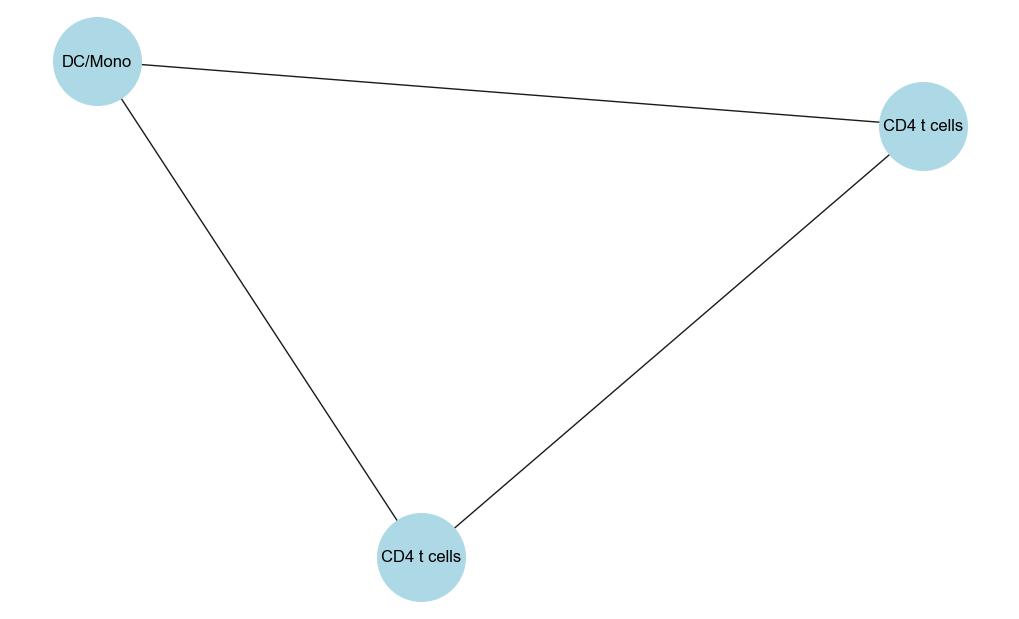

motif_id: 6053164, hash_id: 5203983912965418814


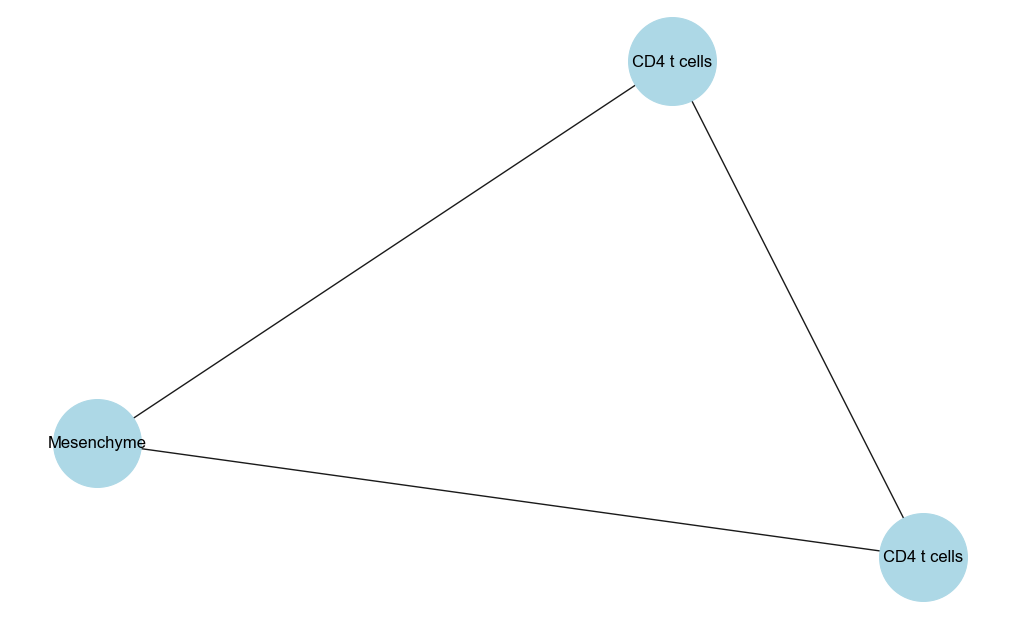

motif_id: 6110508, hash_id: 781045198055153758


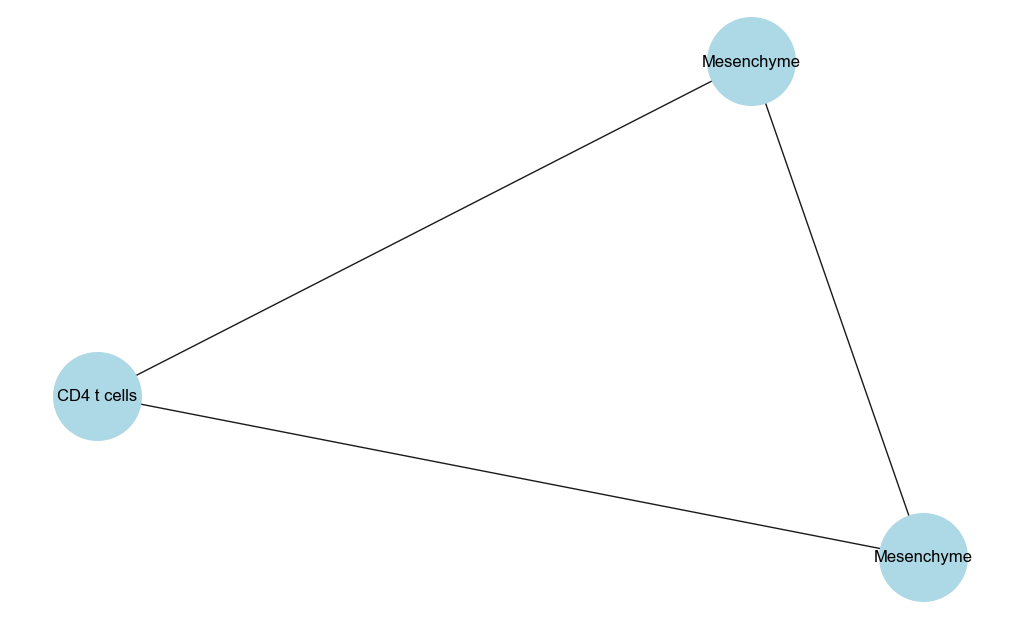

motif_id: 6061228, hash_id: 6512495239480086935


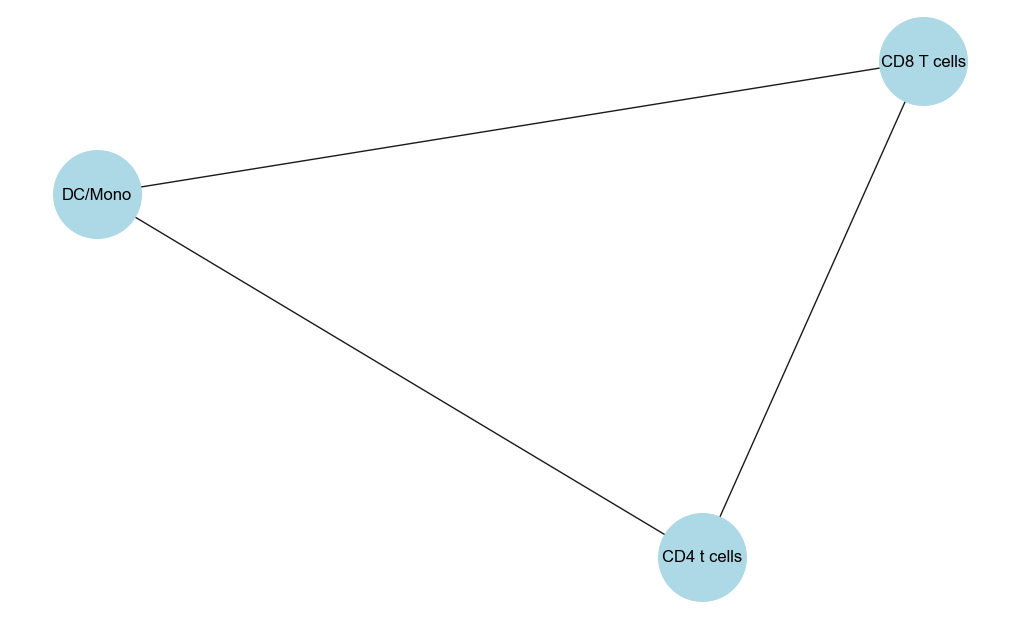

motif_id: 11058348, hash_id: -3622911041628419534


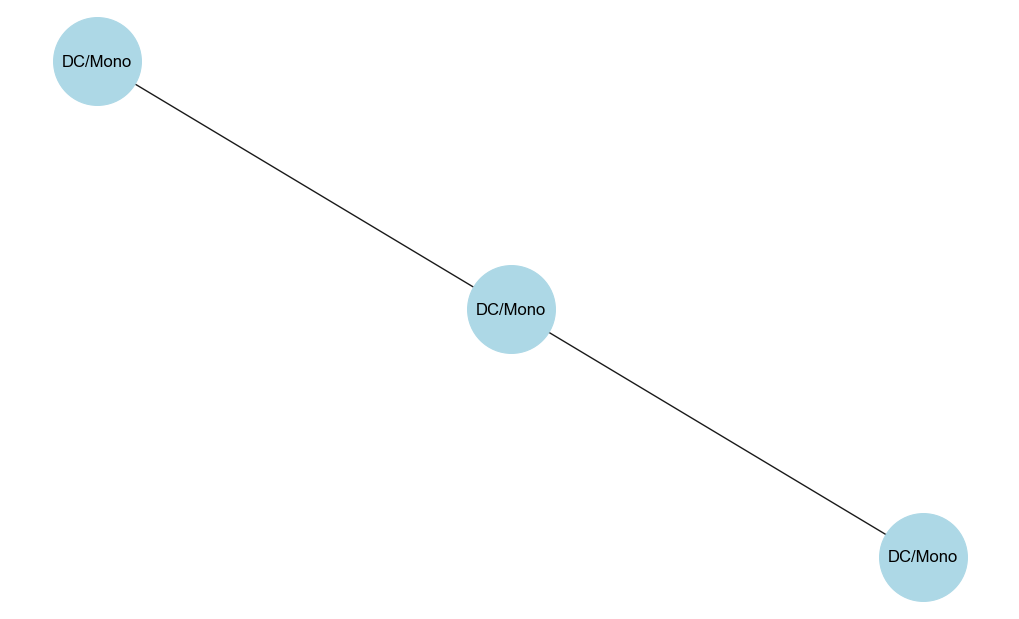

motif_id: 4750508, hash_id: 6512495239480086935


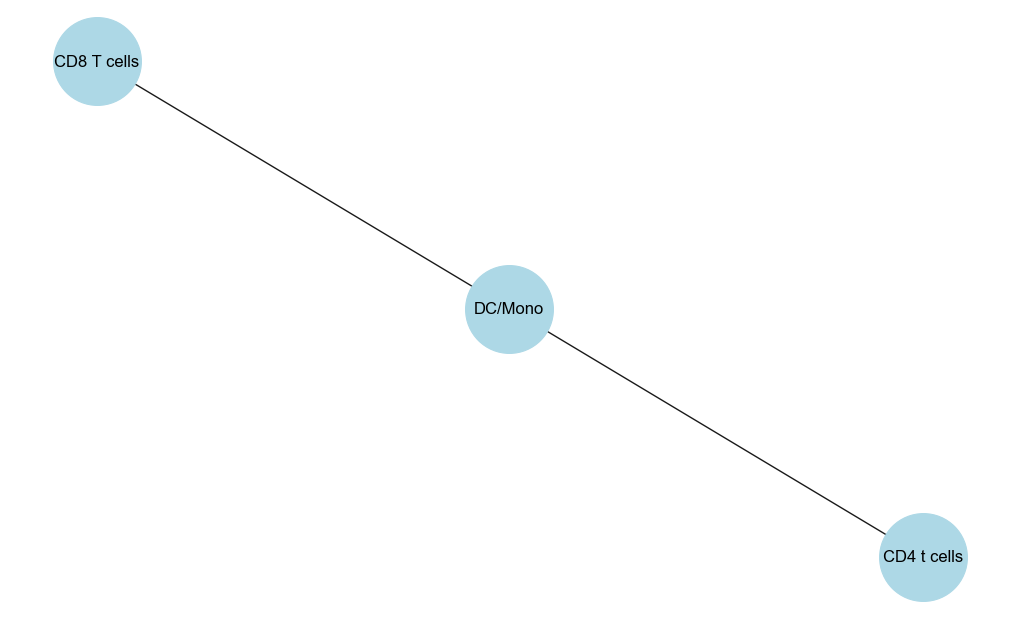

motif_id: 6061356, hash_id: -5592926003202999446


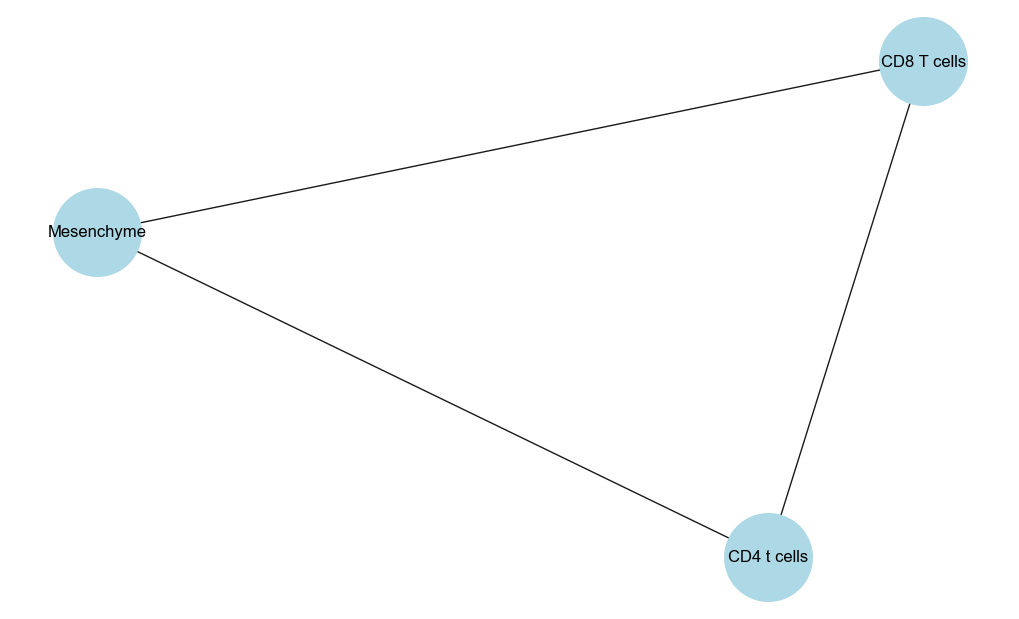

motif_id: 6077612, hash_id: 391868164882289572


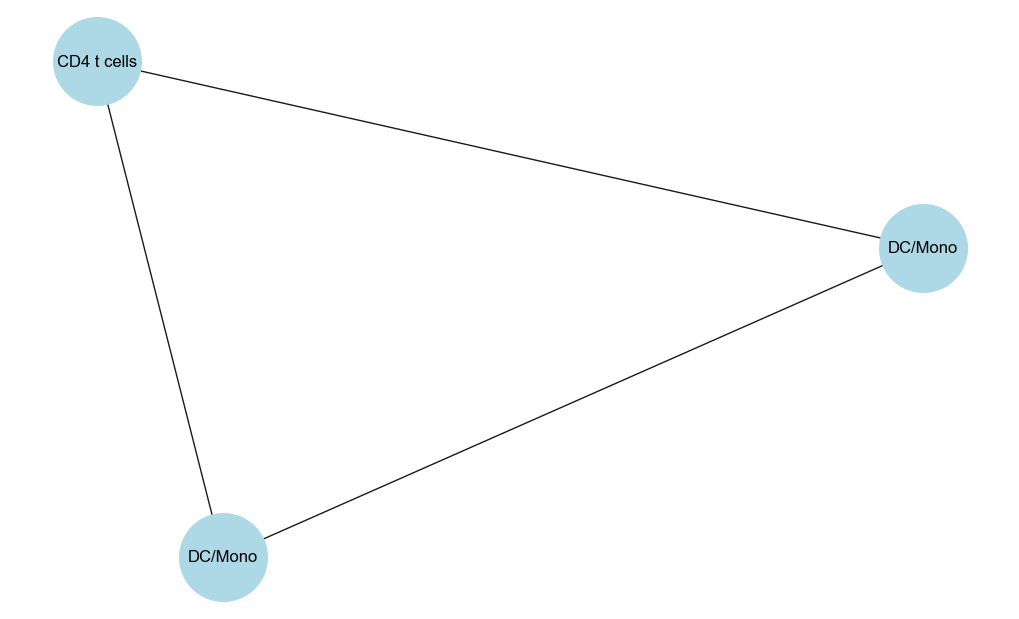

motif_id: 12369068, hash_id: -3622911041628419534


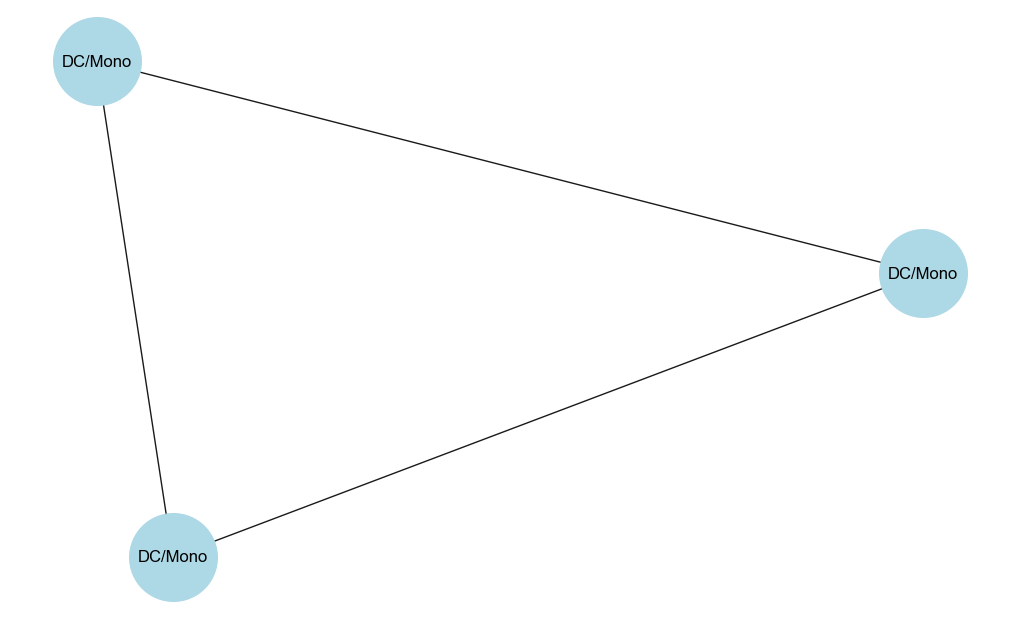

motif_id: 1866924, hash_id: 5566782625218365255


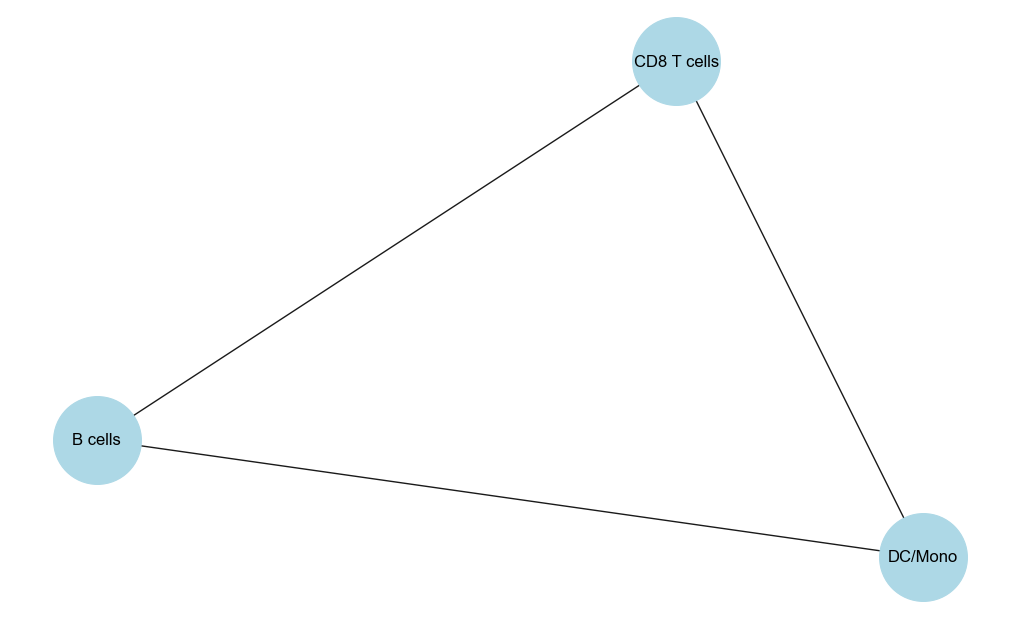

motif_id: 12401964, hash_id: 1839184594750841426


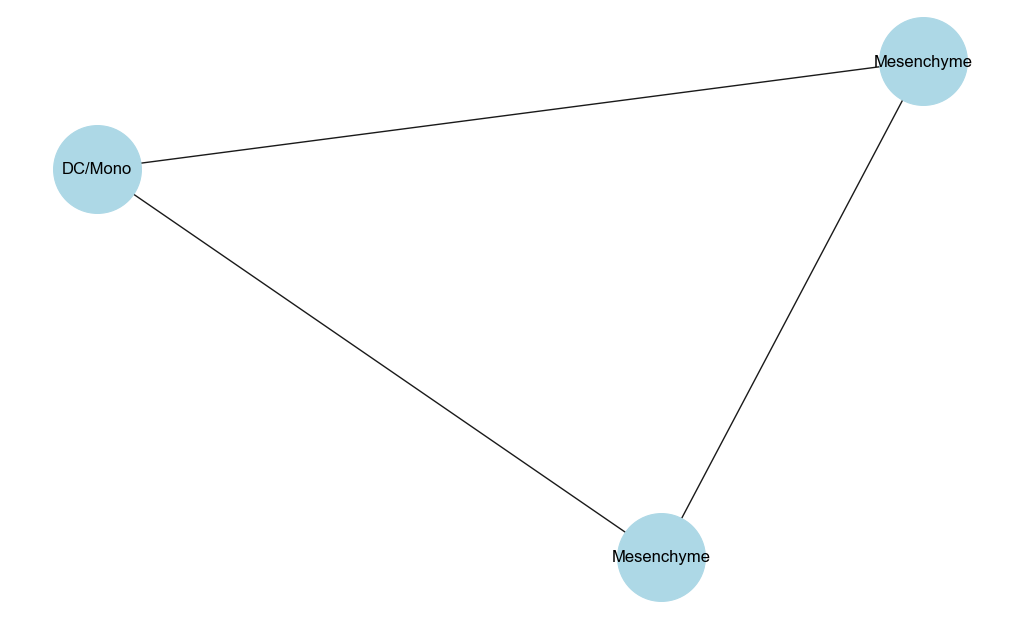

motif_id: 1867212, hash_id: 3846638627528876859


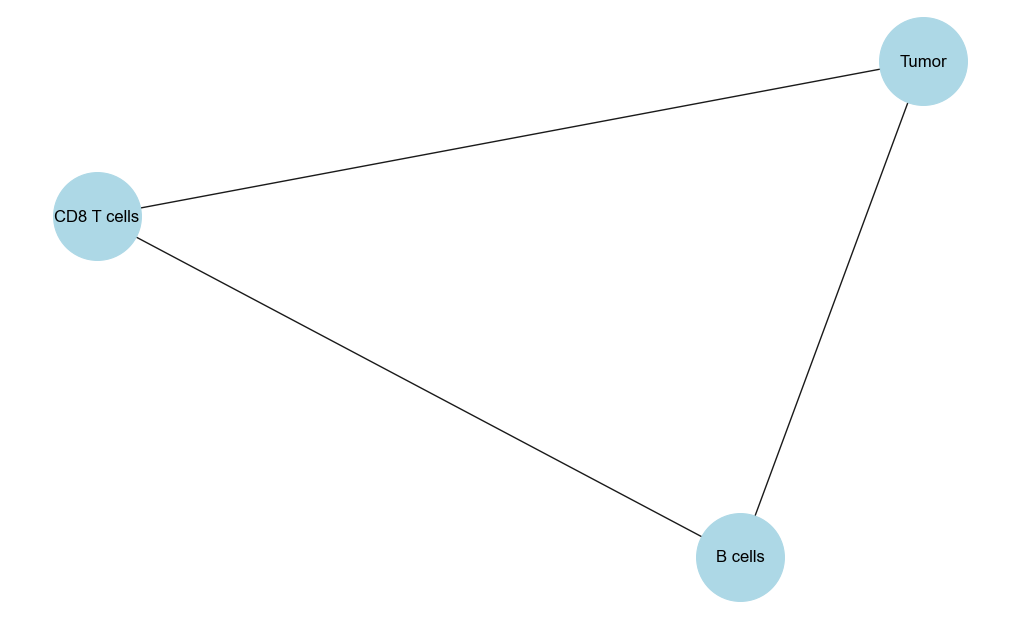

motif_id: 6077900, hash_id: 6794497112851034106


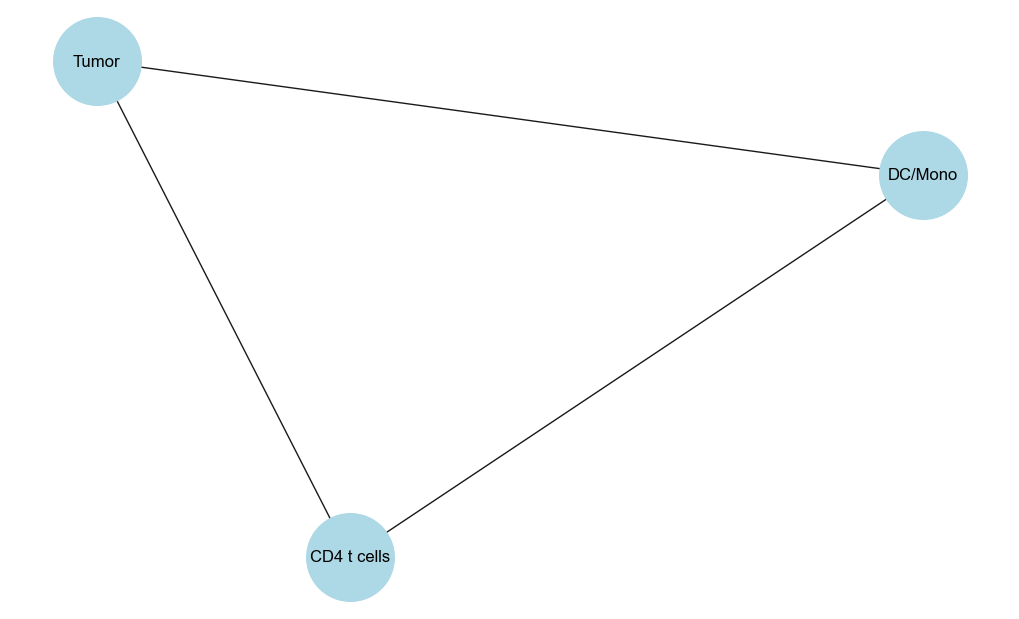

motif_id: 18726348, hash_id: 7044852548982914915


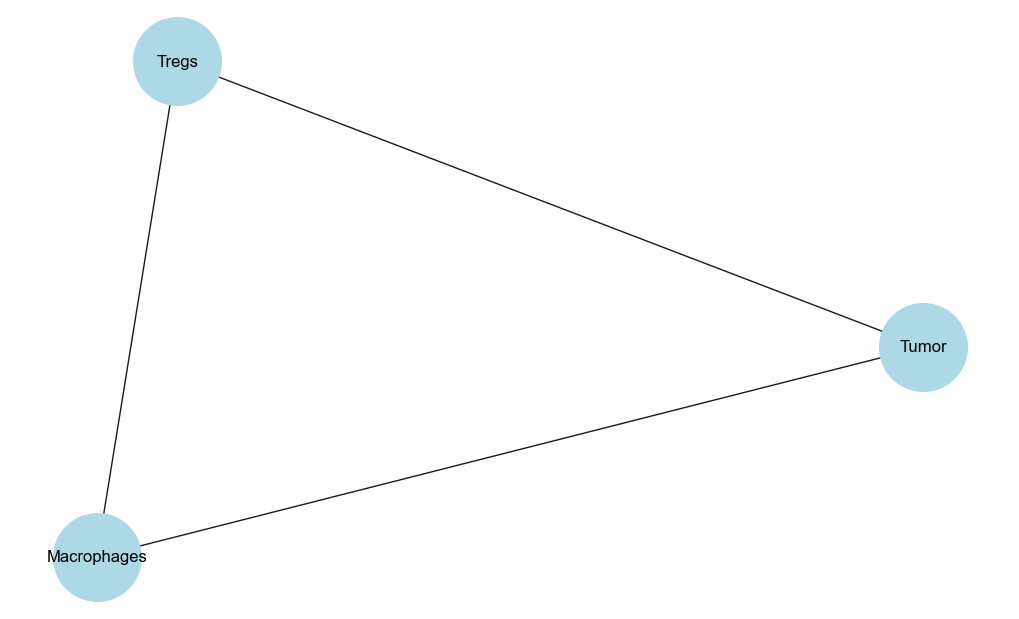

motif_id: 6052940, hash_id: 1592853070812828195


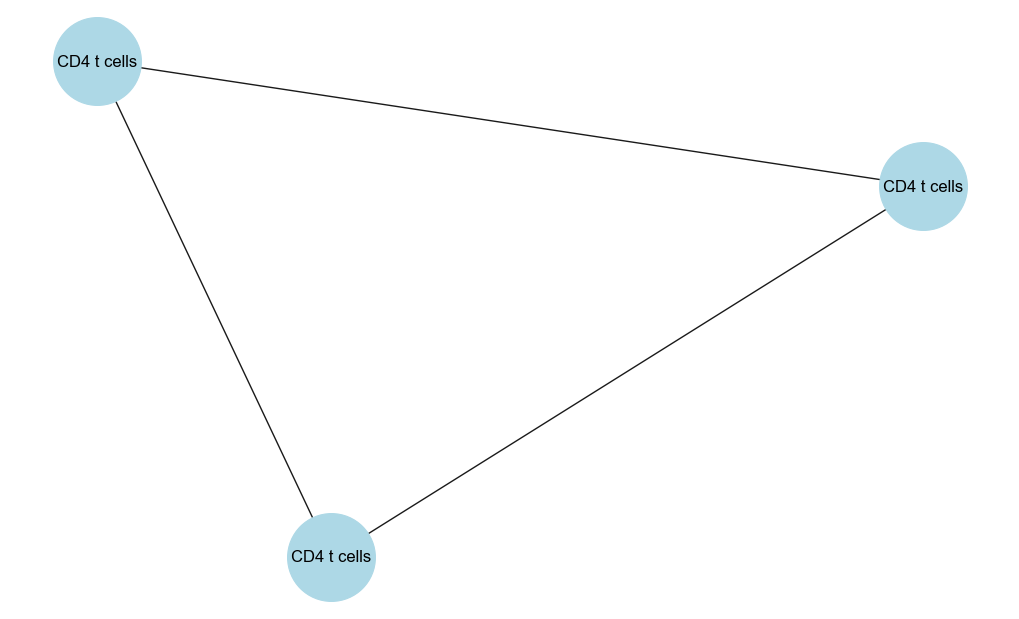

motif_id: 1899980, hash_id: -7904838511589044209


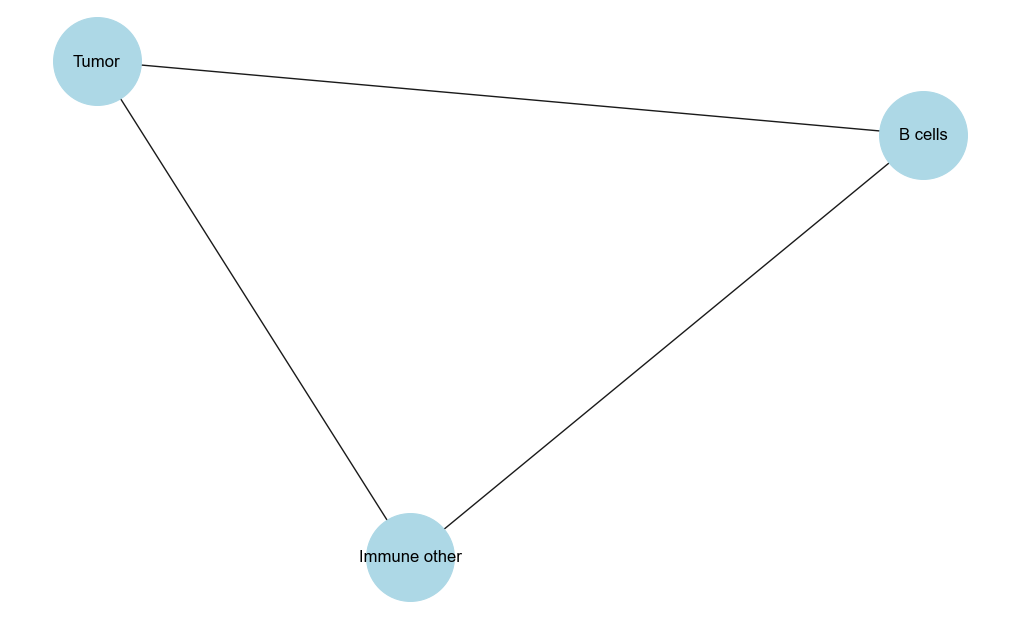

motif_id: 3947980, hash_id: 2384766923162765971


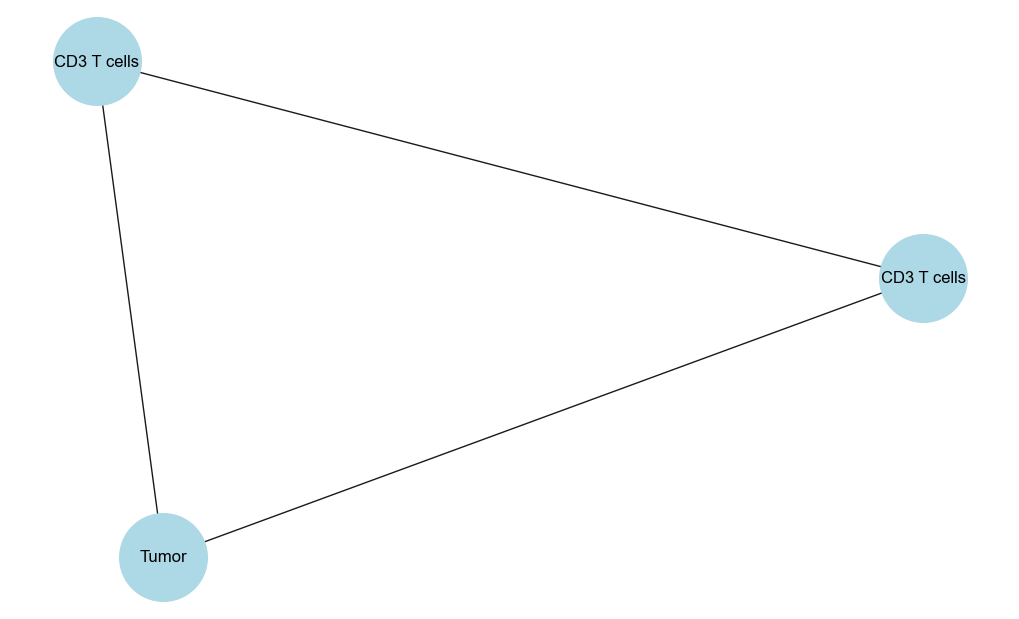

motif_id: 1866860, hash_id: 3580840254939402609


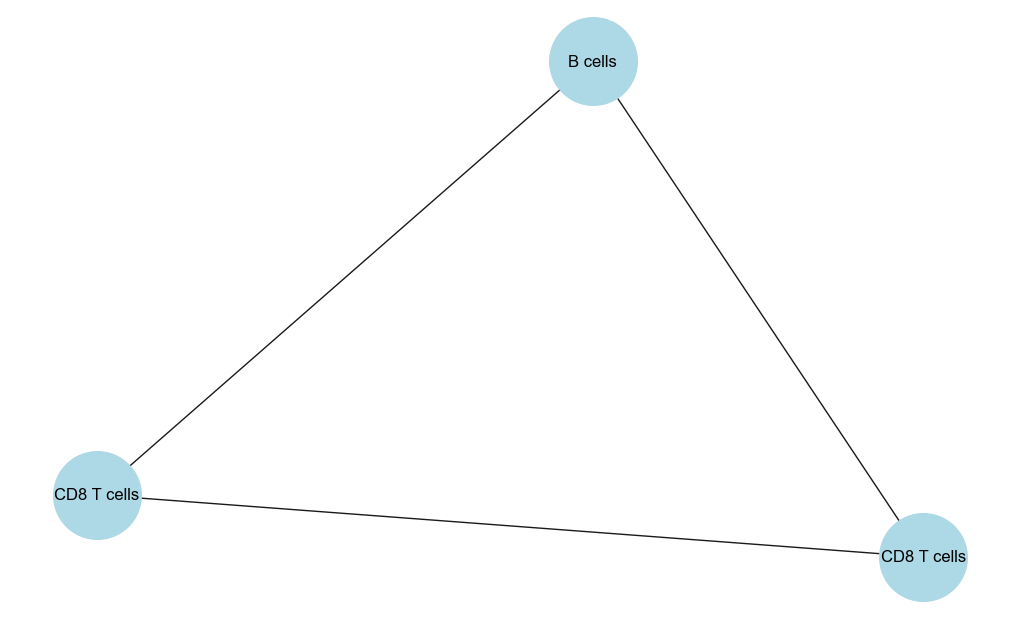

motif_id: 5567724, hash_id: -8232997633730303071


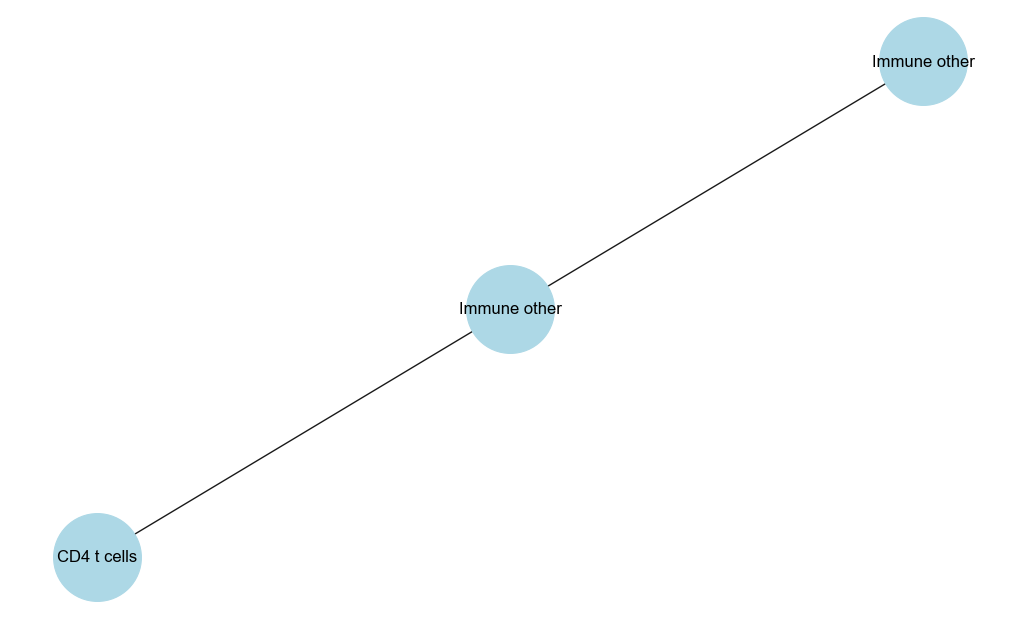

motif_id: 6052972, hash_id: 6296317540562037293


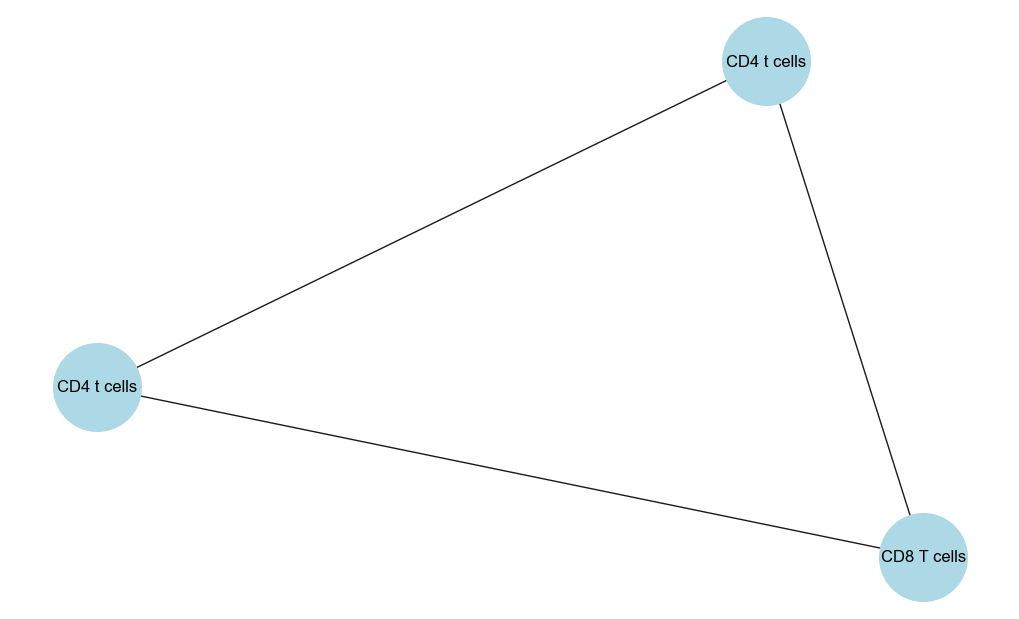

motif_id: 3955948, hash_id: 1953587682041931478


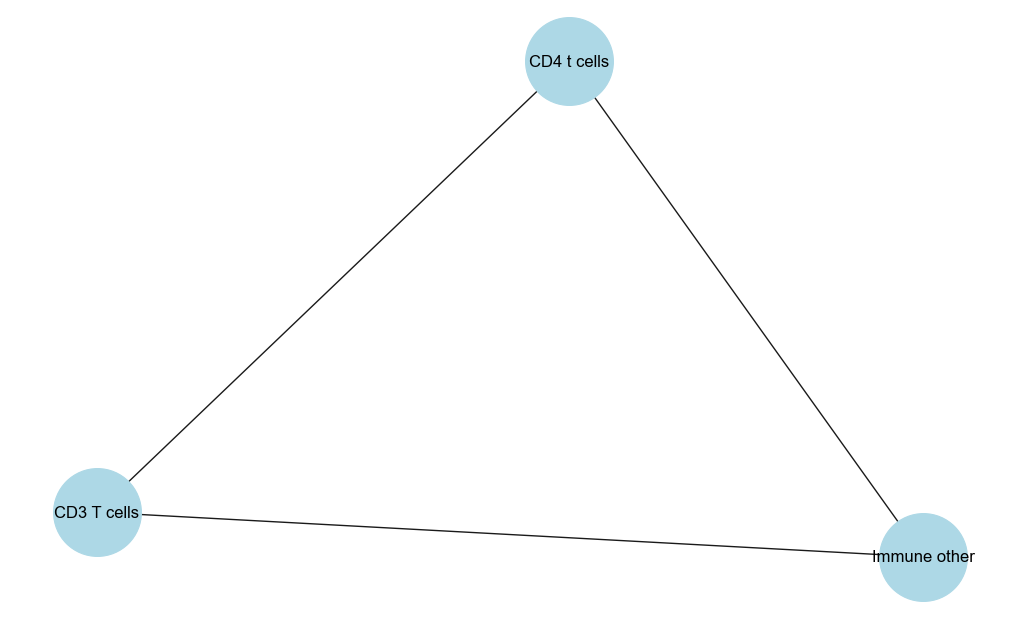

motif_id: 6094060, hash_id: -8232997633730303071


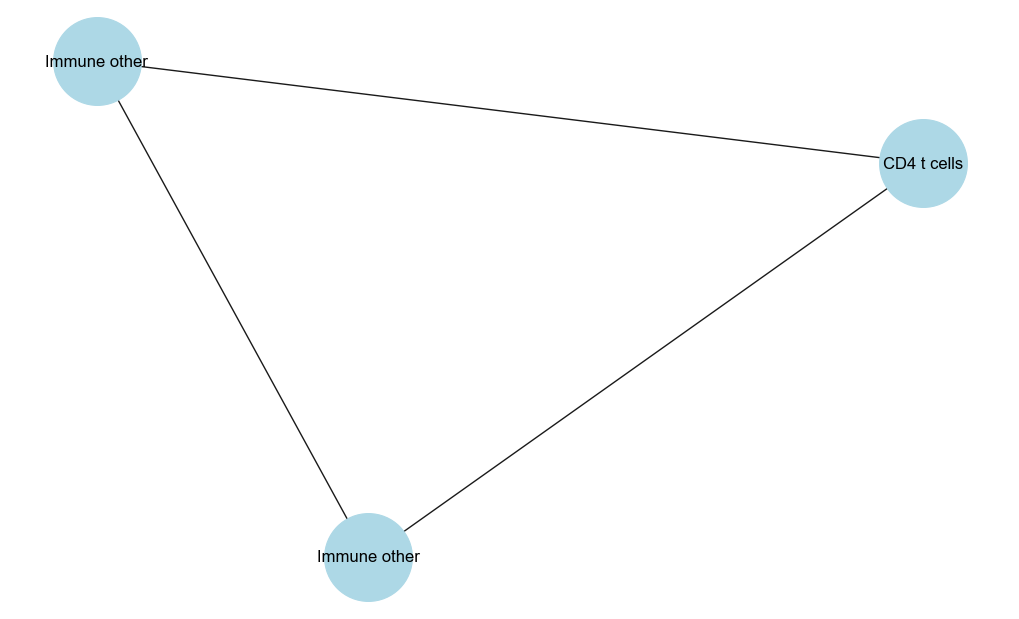

motif_id: 1858668, hash_id: -2723953054276735933


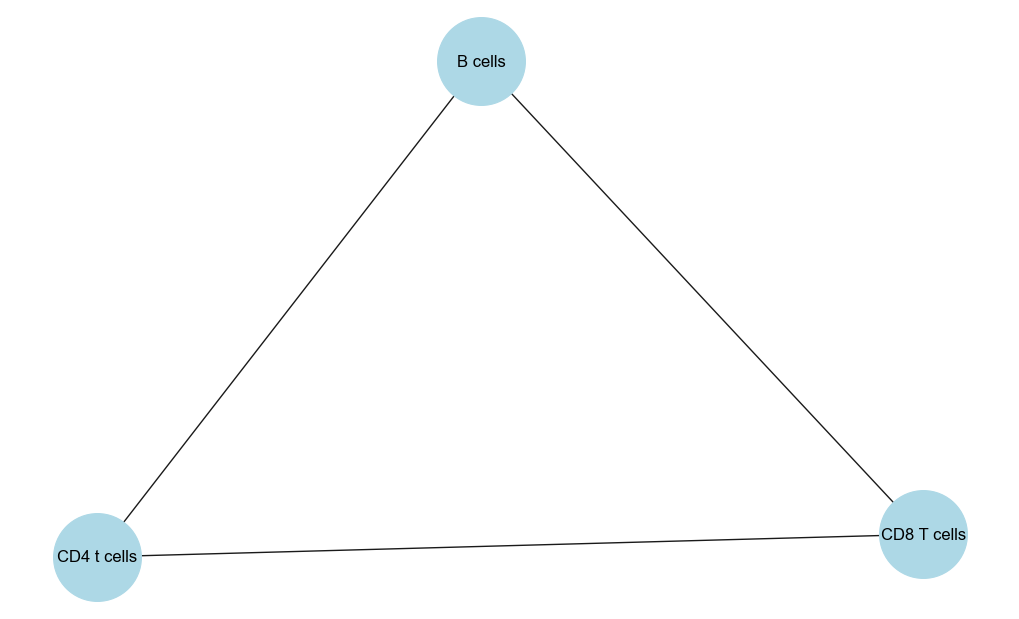

motif_id: 6061292, hash_id: -7193036188506692760


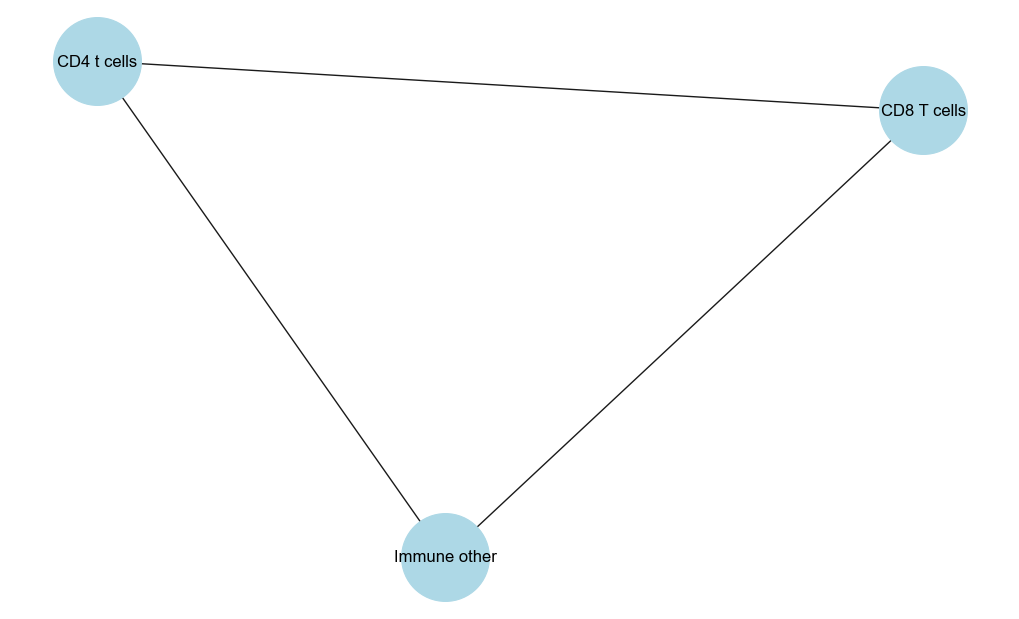

motif_id: 3955820, hash_id: 4620830178405356214


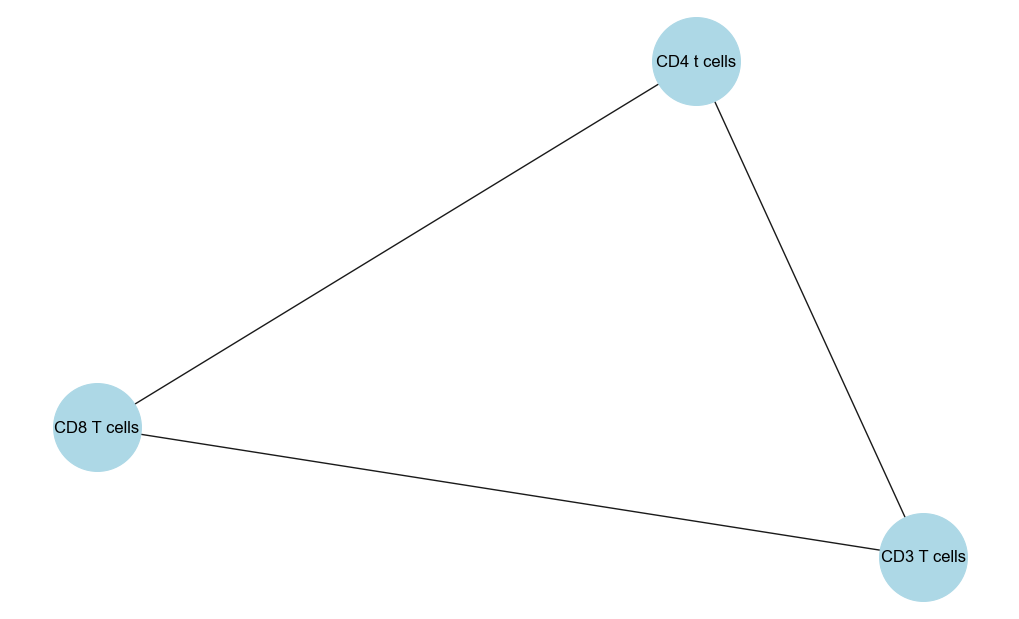

motif_id: 16574956, hash_id: 298217543138803088


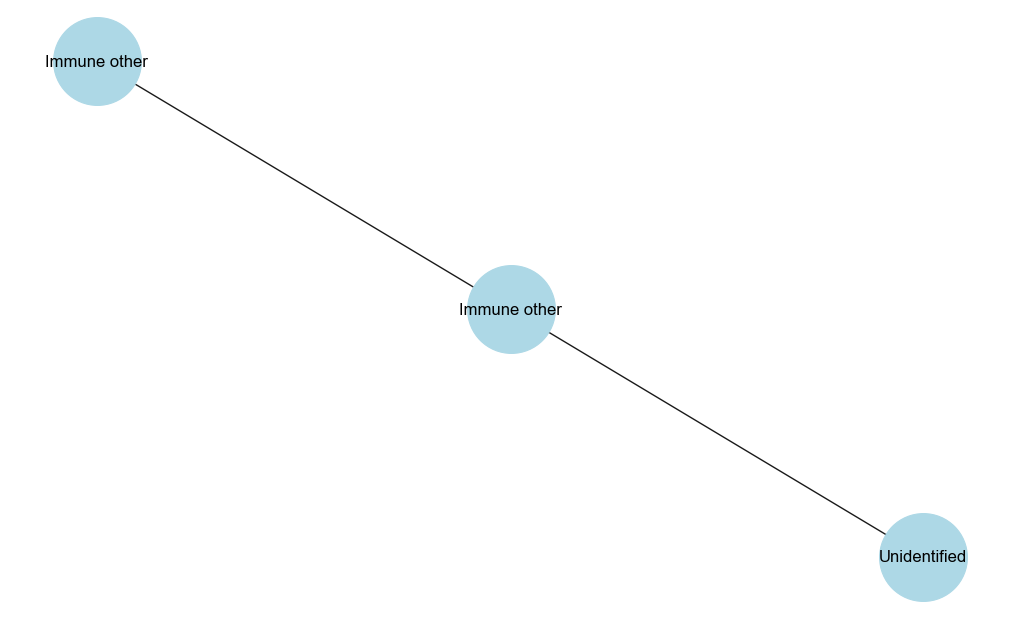

motif_id: 3470828, hash_id: 1308949138443113395


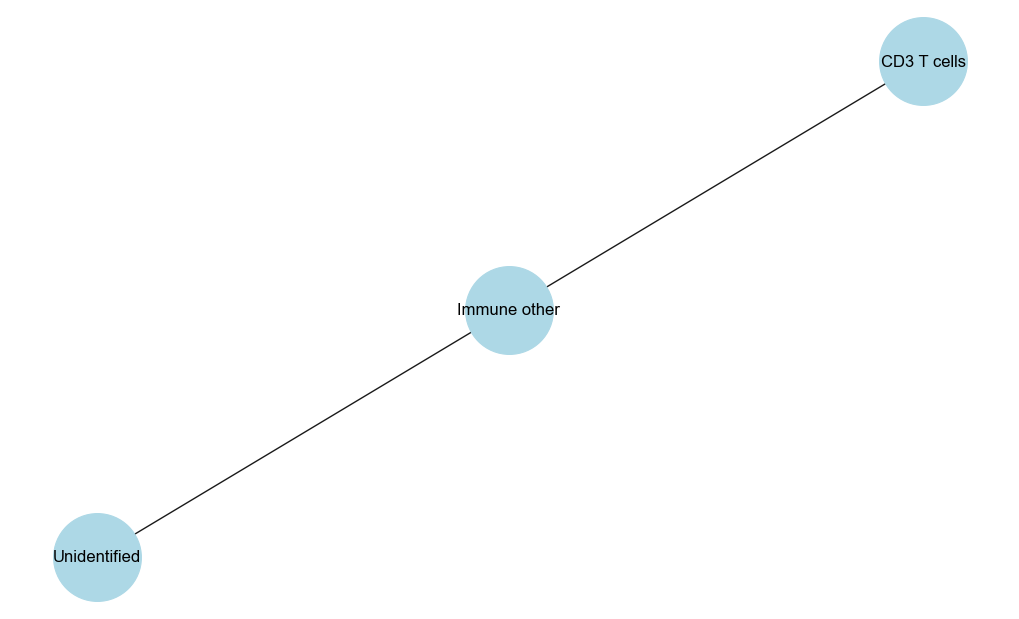

In [25]:
from cism import helpers
from cism.vis import draw

for motif_id in get_motifs_result.all_motif_features:
    hash_id = get_motifs_result.motif_to_cells_identity_hash[motif_id]
    print(f'motif_id: {motif_id}, hash_id: {hash_id}')
    target_motif = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].iloc[0].motif
    target_motif = helpers.string_base64_pickle(target_motif)
    draw.draw_motif(target_motif, cells_type=cells_type)